# Final Project Submission


* Student name: Vadym Byesyedin
* Student pace: self paced
* Scheduled project review date/time: 04/06/2021 17:00 EST
* Instructor name: Jeff Herman
* Blog post URL: https://vadym-byesyedin.medium.com/multiple-linear-regression-in-python-using-statsmodels-and-sklearn-94190473c2e6


# Contents
* #### EDA
  * Import and explore data
  * Initial data visualization
  * Data cleaning
  * Remove outliers
  * Clean data visualization
  * Normalize data
  * Plot data on map
* #### Questions
  * What is dependence between `sqft_living` vs `price` and `sqft_lot` vs `price`?
  * Is there a difference in price based on the renovation status within the last 10 years or 10+ years with respect to square footage of living area?
  * Does the price depend on the number of bedrooms?
  * How did the price change over the time for the subset of data for which this data is available?
* #### Build Model
  * Linear regression using Statsmodels
  * Cross validation
  * Linear regression using scikit-learn
  * Visualizing prediction accuracy
* #### Recommendations

# EDA

#### Import file with helper functions

In [7]:
%run functions.py

### Import and explore data

In [2]:
import pandas as pd

raw_df = pd.read_csv("kc_house_data.csv")

display(raw_df.head())
display(raw_df.info())
display(raw_df.nunique())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

None

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

#### Select categorical and continious data columns to use in model

In [3]:
categorical = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade','yr_built','yr_renovated','zipcode']
continious = ['price','sqft_living','sqft_lot','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15']
outcome = 'price'

### Initial data visualization

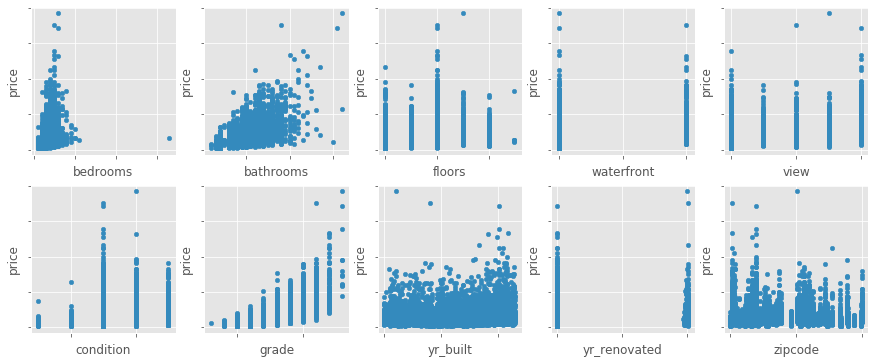

In [32]:
print_scatter(raw_df,categorical,outcome)

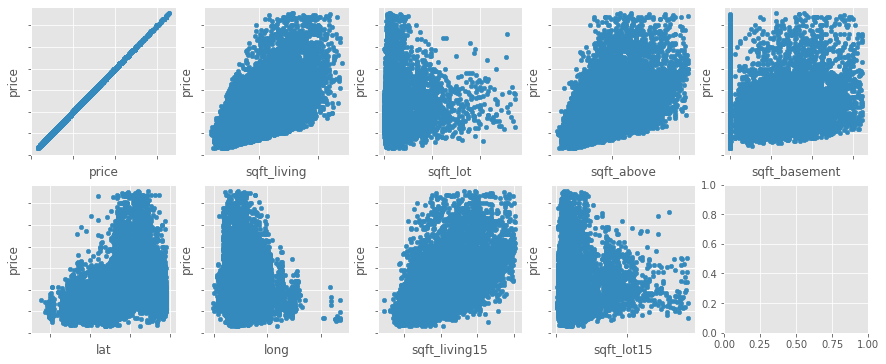

In [33]:
print_scatter(df,continious,outcome)

### Data cleaning

#### Check for NaN

In [4]:
raw_df.isna().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront        True
view              True
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated      True
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

#### Convert NaN to 0
`waterfront`, `view` and `yr_renovated` have NaN values.<br>
It's appropriate set them to 0<br>
Also cast them to int

In [9]:
raw_df = raw_df.fillna(0)
raw_df.waterfront = raw_df.waterfront.astype(np.int64)
raw_df.view = raw_df.view.astype(np.int64)
raw_df.yr_renovated = raw_df.yr_renovated.astype(np.int64)

#### Fix `sqft_basement` column

In [10]:
raw_df.sqft_basement = raw_df.sqft_basement.replace('?',0)
raw_df.sqft_basement = raw_df.sqft_basement.astype(np.float64)

#### trim data

In [11]:
raw_df = raw_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#### Remove outliers
(more than 3 std)

In [12]:
from scipy import stats
possible_outliers_cols = ['price','sqft_living','sqft_lot','sqft_above',
                          'sqft_basement','sqft_living15','sqft_lot15']
df = raw_df[(np.abs(stats.zscore(raw_df[possible_outliers_cols])) < 3).all(axis=1)]

# Remove 1 row with '33' value in bedrooms column as outlier
# print(df.bedrooms.max())
df = df[df.bedrooms != 33]

# Remove 1 row with '7.5' value in bathrooms column as outlier
# print(df.bathrooms.max())
df = df[df.bathrooms != 7.5]

print_reduce_perc(raw_df,df)

'Dataframe length -  before: 21597, after: 20339. Size reduction: 5.82%'

### Clean data visualization

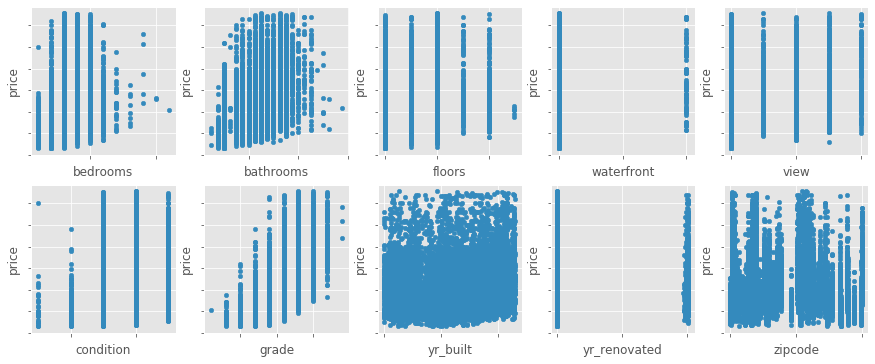

In [34]:
print_scatter(df,categorical,outcome)

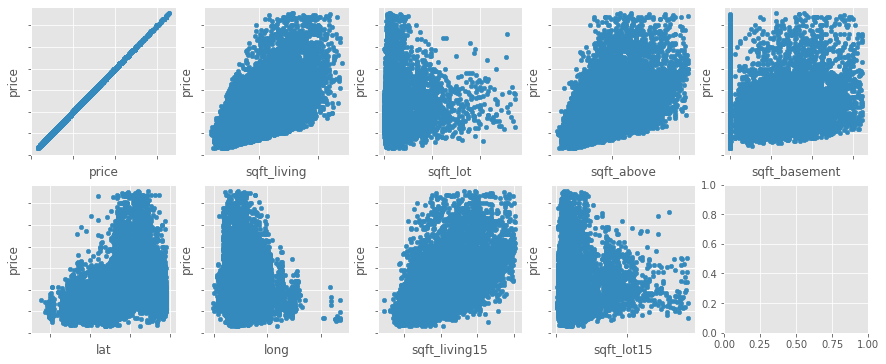

In [35]:
print_scatter(df,continious,outcome)

### Normalize data

#### Check data distribution

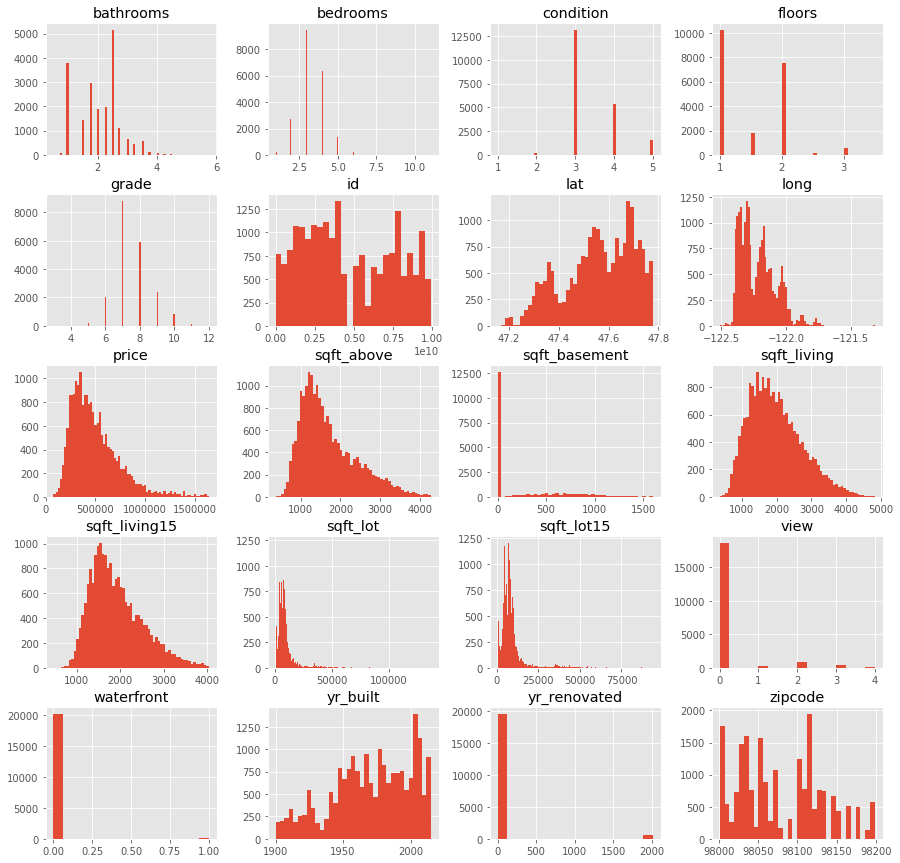

In [36]:
print_hist(df)

#### Cut df ot make data more normal
The `price`,`sqft_living`,`sqft_lot` are skewed, so we'll try to make them more normal

In [13]:
cropped_df = df[df['price'] < 1000000]
cropped_df = cropped_df[cropped_df['sqft_lot'] < 20000]
cropped_df = cropped_df[cropped_df['bedrooms'] < 7.5]

print_reduce_perc(df,cropped_df)

'Dataframe length -  before: 20339, after: 17990. Size reduction: 11.55%'

#### Check cropped data distribution

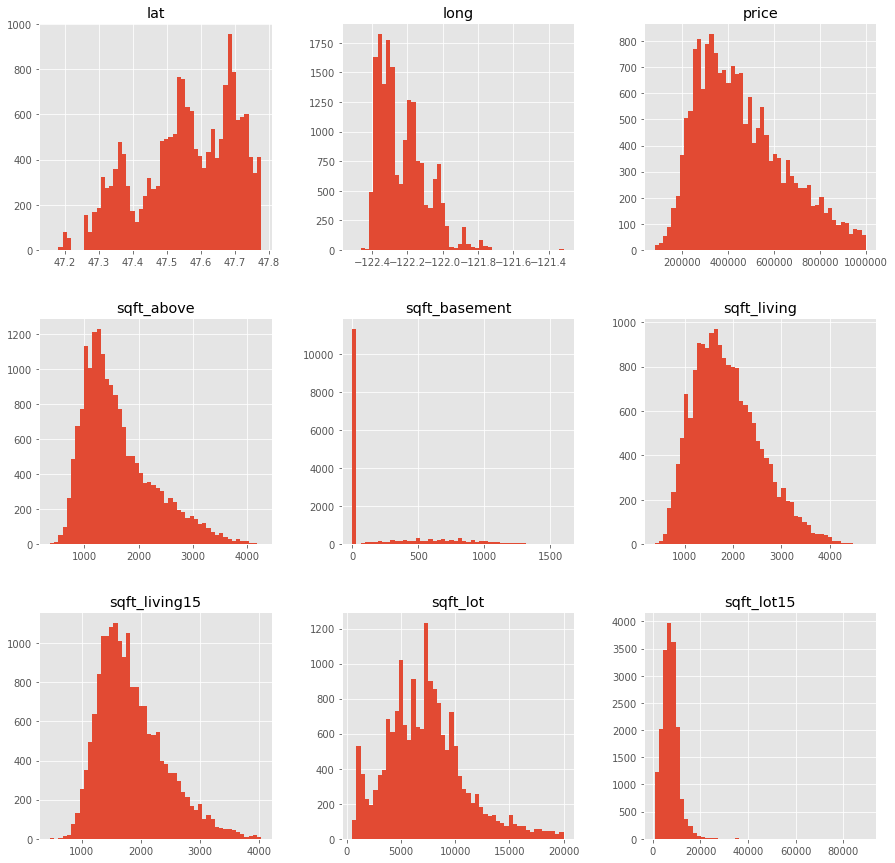

In [74]:
print_hist(cropped_df[continious], bins=50)

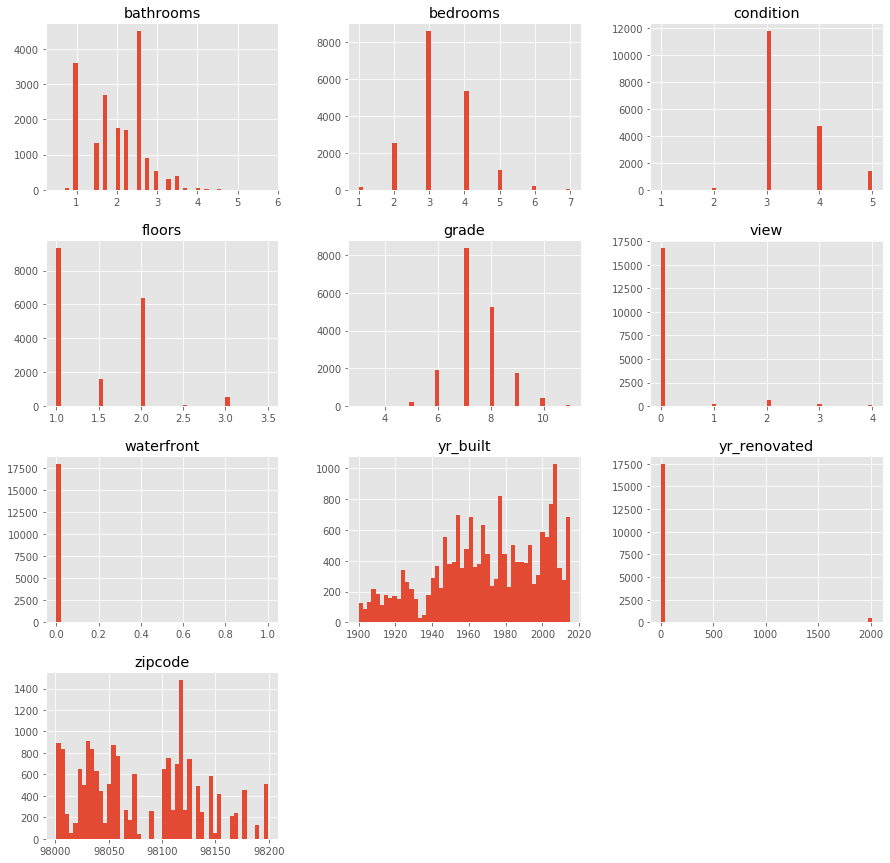

In [262]:
print_hist(cropped_df[categorical], bins=50)

### Plot data on map
print min and max values to export image from <a href="https://www.openstreetmap.org/">openstreetmap.org</a>

In [14]:
BBox = ((cropped_df.long.min(),   cropped_df.long.max(),      
         cropped_df.lat.min(), cropped_df.lat.max()))

BBox

(-122.512, -121.315, 47.1559, 47.7776)

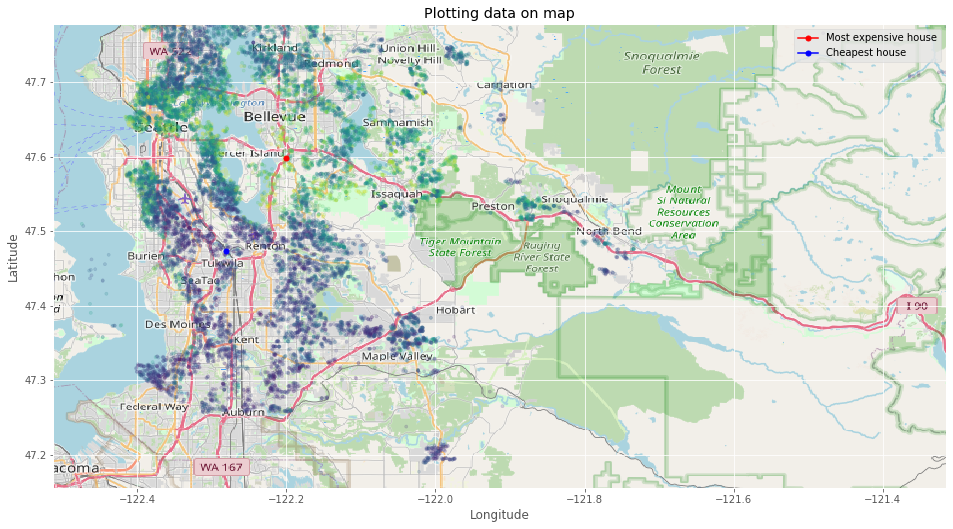

In [15]:
fig, ax = plt.subplots(figsize = (16,10))
ax.scatter(cropped_df.long, cropped_df.lat, zorder=1, alpha= 0.2, c=cropped_df.price, s=10)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_title('Plotting data on map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

exp = cropped_df[cropped_df['price'] == cropped_df.price.max()][['long','lat']]
chp = cropped_df[cropped_df['price'] == cropped_df.price.min()][['long','lat']]

ax.plot(exp.long,exp.lat,c='r',markersize=5, marker='o', label="Most expensive house")
ax.plot(chp.long,chp.lat,c='b',markersize=5, marker='o', label="Cheapest house")
ax.legend(loc=1)

map_img = plt.imread('map.png')
ax.imshow(map_img, zorder=0, extent = BBox, aspect= 'equal');

# Questions

### What is dependence between `sqft_living` vs `price` and `sqft_lot` vs `price`?
From the visualization below we can see that square footage of living area impact price hardly with coefficient ~159.<br>
And square footage of lot has slight negative impact on price with coefficient -1.29.<br>
Sqft of living area impacts price about 100 times more than sqft of lot area.

sqft_living coefficient: 158.76592019128037
sqft_lot coefficient: -1.2912347265002777


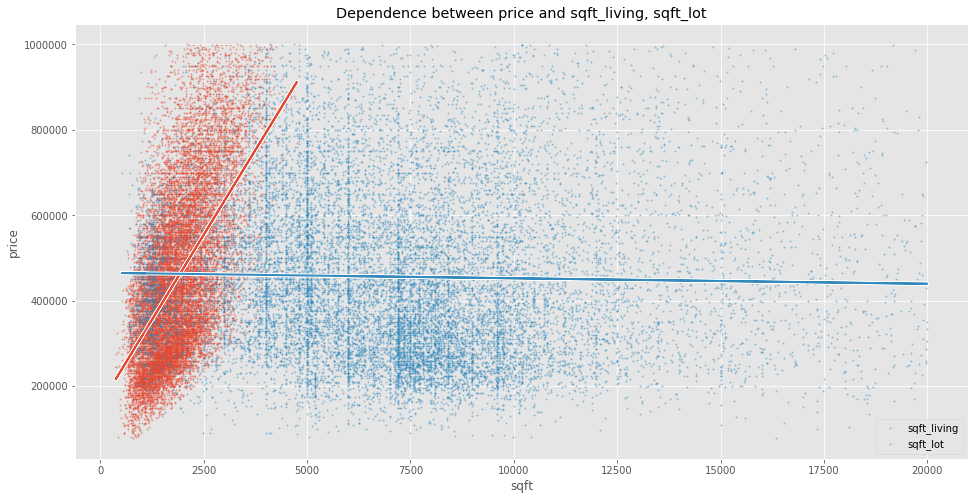

In [58]:
print_comparison(cropped_df[['sqft_living','price']],cropped_df[['sqft_lot','price']], x_label="sqft")

### Is there a difference in price based on the renovation status within the last 10 years or 10+ years with respect to square footage of living area?
From the visualization below we can see that year of renovation does not have an impact on house price.

sqft_living coefficient: 178.18482410890576
sqft_living coefficient: 178.85264575406347


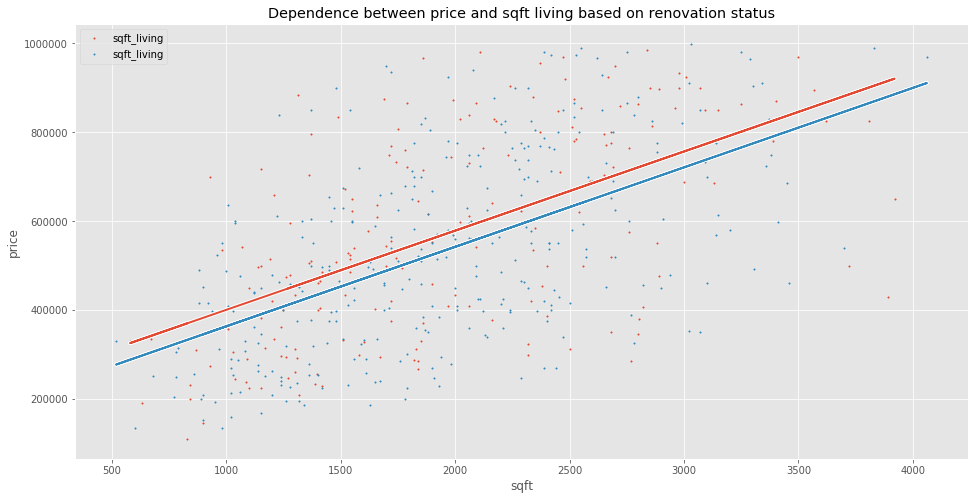

In [57]:
renovated_df = cropped_df[cropped_df.yr_renovated > 0]
renovated_df_less_10 = renovated_df[renovated_df.yr_renovated >= renovated_df.yr_renovated.max() - 10]
renovated_df_more_10 = renovated_df[renovated_df.yr_renovated < renovated_df.yr_renovated.max() - 10]
print_comparison(
    renovated_df_less_10[['sqft_living','price']],
    renovated_df_more_10[['sqft_living','price']], 
    title="Dependence between price and sqft living based on renovation status",
    x_label="sqft",
    alpha=1
)

### Does the price depend on the number of bedrooms? 
There is a notable difference in price between 1br and 2br apartments, as seen from the violin plot.<br>
The following increase in Br does not produce such a difference

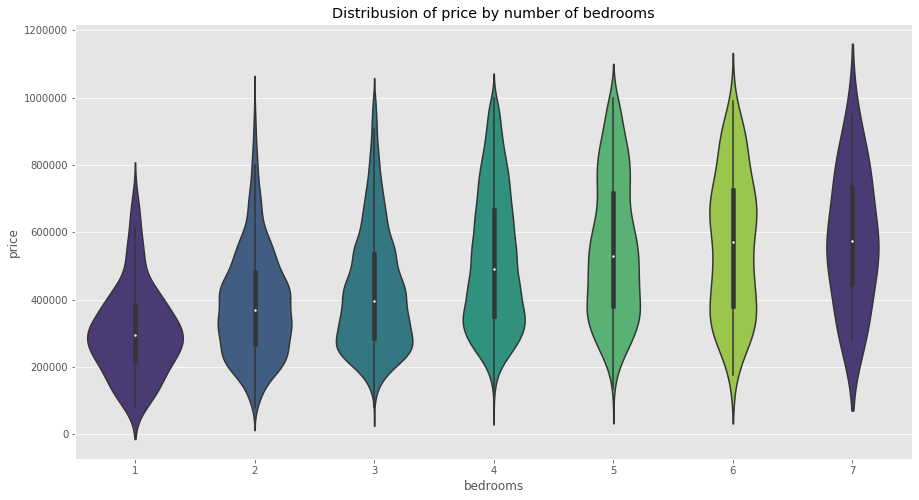

In [59]:
plt.figure(figsize=(15,8))
sns.violinplot(x="bedrooms", y="price", data=cropped_df,palette=sns.color_palette("viridis"))
plt.title('Distribusion of price by number of bedrooms');

Check significance with ANOVA

In [68]:
formula_b = 'price ~ sqft_living + C(zipcode) + C(grade) + C(bedrooms)'
lm = ols(formula_b, cropped_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq       df            F        PR(>F)
C(zipcode)   2.585771e+14     69.0   535.594470  0.000000e+00
C(grade)     1.399371e+13      8.0   249.998829  0.000000e+00
C(bedrooms)  5.728159e+11      6.0    13.644539  1.598807e-15
sqft_living  4.209516e+13      1.0  6016.269124  0.000000e+00
Residual     1.252793e+14  17905.0          NaN           NaN


### How did the price change over the time for the subset of data for which this data is available?
Select duplicated ids

In [108]:
duplicated_df = df[df.id.duplicated(keep=False)].sort_values('id')
duplicated_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2494,1000102,9/16/2014,280000.0,6,3.00,2400,9373,2.0,0,0,...,7,2400,0.0,1991,0,98002,47.3262,-122.214,2060,7316
2495,1000102,4/22/2015,300000.0,6,3.00,2400,9373,2.0,0,0,...,7,2400,0.0,1991,0,98002,47.3262,-122.214,2060,7316
16801,7200179,4/24/2015,175000.0,2,1.00,840,12750,1.0,0,0,...,6,840,0.0,1925,0,98055,47.4840,-122.211,1480,6969
16800,7200179,10/16/2014,150000.0,2,1.00,840,12750,1.0,0,0,...,6,840,0.0,1925,0,98055,47.4840,-122.211,1480,6969
11422,109200390,10/20/2014,250000.0,3,1.75,1480,3900,1.0,0,0,...,7,1480,0.0,1980,0,98023,47.2977,-122.367,1830,6956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6340,9828200460,1/6/2015,430000.0,2,1.00,700,4800,1.0,0,0,...,7,700,0.0,1922,0,98122,47.6147,-122.300,1440,4800
15185,9834200305,7/16/2014,350000.0,3,1.00,1790,3876,1.5,0,0,...,7,1090,0.0,1904,0,98144,47.5750,-122.288,1360,4080
15186,9834200305,2/10/2015,615000.0,3,1.00,1790,3876,1.5,0,0,...,7,1090,700.0,1904,0,98144,47.5750,-122.288,1360,4080
1084,9834200885,7/17/2014,360000.0,4,2.50,2080,4080,1.0,0,0,...,7,1040,1040.0,1962,0,98144,47.5720,-122.290,1340,4080


Convert data column (object) to date type and change format (without days).<br>
Sort values by date<br>
Group DF by date column

In [90]:
duplicated_df['date'] = pd.to_datetime(duplicated_df.date).dt.strftime('%Y-%m')
duplicated_df.sort_values('date', inplace=True)
duplicated_df_grouped = pd.DataFrame( duplicated_df.groupby('date')['price'].mean() ).reset_index()

Visualize data

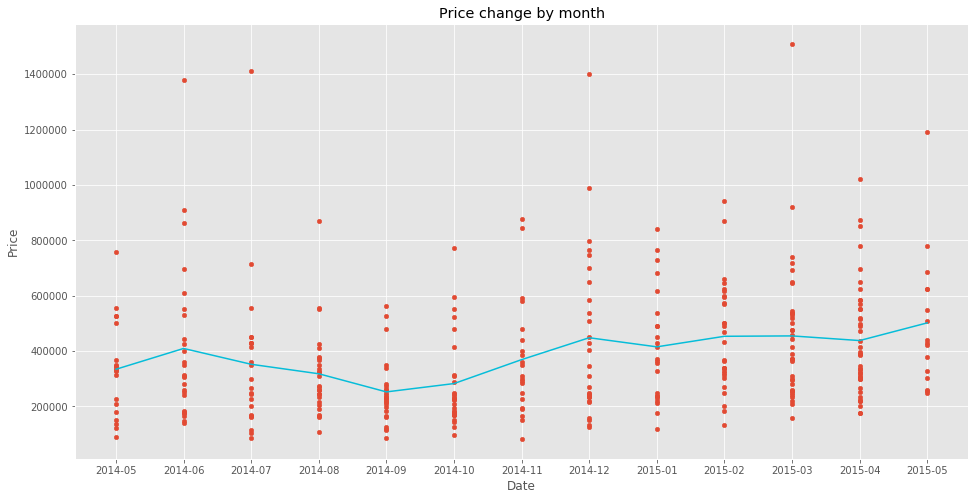

In [106]:
plt.figure(figsize=(16,8))
plt.scatter(duplicated_df.date, duplicated_df.price, s=20)
plt.plot(duplicated_df_grouped.date, duplicated_df_grouped.price, c="#06BDD9")
plt.title("Price change by month")
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

Conclusion:

In [131]:
d_df_start_price = round( duplicated_df_grouped[duplicated_df_grouped.date == '2014-05'].price[0],2 ) 
d_df_end_price = round( duplicated_df_grouped[duplicated_df_grouped.date == '2015-05'].price[12],2 ) 
print(f'The price increased from ${d_df_start_price} on 05/2014 to ${d_df_end_price} as of 05/2015')
print(f'The price increased by { round( (d_df_end_price*100) / d_df_start_price,0 ) }%')

The price increased from $334020.11 on 05/2014 to $501558.75 as of 05/2015
The price increased by 150.0%


# Build Model

I have tried to stepwise selection and recursive feature elimenation (RFE) but it didn't give meanful results.<br>
So I manually iterate over features and select minimum number of significant features.<br>
Next features do not change R squares significantly:
* bedrooms
* bathrooms
* view
* floors
* condition
* waterfront
* long
* sqft_lot
* sqft_lot15
* sqft_living15
* yr_renovated

Log transformation and normalization of  predictors did not increase R squared value significantly and complicated interpretation of the results.

In [75]:
cat_cols = ['zipcode','grade']
cont_cols = ['sqft_living']

df_ohe = pd.get_dummies(cropped_df[cat_cols], columns=cat_cols, drop_first=True)
df_ohe.columns = df_ohe.columns.str.replace('.', '_')

# df_log_norm = log_norm(cropped_df,['price','sqft_living','sqft_lot'])
# X = pd.concat([df_log_norm[['sqft_living']], df_ohe], axis=1)
# y = df_log_norm[outcome]

X = pd.concat([cropped_df[cont_cols], df_ohe], axis=1)
y = cropped_df[outcome]

### Linear regression using Statsmodels

In [76]:
const_X = sm.add_constant(X)

model = sm.OLS(y, const_X)
linreg = model.fit()

linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     970.3
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:02:35   Log-Likelihood:            -2.2943e+05
No. Observations:               17990   AIC:                         4.590e+05
Df Residuals:                   17911   BIC:                         4.596e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.761e+05   8.42e+04      2.090      0.037    1.09e+04    3.41e+05
sqft_living     119.5337      1.268     94.300      0.000     117.049     122.018
zipcode_98002  1.225e+04   7655.855      1.600      0.110   -2758.072    2.73e+04
zipcode_98003  9908.6262   7026.819      1.410      0.159   -3864.616    2.37e+04
zipcode_98004  5.184e+05   8910.129     58.183      0.000    5.01e+05    5.36e+05
zipcode_98005  3.511e+05   9263.436     37.896      0.000    3.33e+05    3.69e+05
zipcode_98006  2.911e+05   6634.642     43.873      0.000    2.78e+05    3.04e+05
zipcode_98007  2.639e+05   8770.102     30.096      0.000    2.47e+05    2.81e+05
zipcode_98008  2.617e+05   7098.270     36.865      0.000    2.48e+05    2.76e+05
zipcode_98010  9.993e+04   1.25e+04      8.004      0.000    7.55e+04    1.24e+05
zipcode_98011  1.523e+05   7838.422     19.426      0.000    1.37e+05    1.68e+05
zipcode_98014  1.027e+05   1.25e+04      8.204      0.000    7.82e+04    1.27e+05
zipcode_98019  9.642e+04   8463.176     11.393      0.000    7.98e+04    1.13e+05
zipcode_98022  2.377e+04   8381.008      2.837      0.005    7346.413    4.02e+04
zipcode_98023 -1.285e+04   6140.152     -2.092      0.036   -2.49e+04    -810.390
zipcode_98024   1.32e+05   1.68e+04      7.837      0.000     9.9e+04    1.65e+05
zipcode_98027   2.27e+05   7175.565     31.631      0.000    2.13e+05    2.41e+05
zipcode_98028  1.424e+05   7107.961     20.036      0.000    1.28e+05    1.56e+05
zipcode_98029  2.273e+05   6885.052     33.007      0.000    2.14e+05    2.41e+05
zipcode_98030  6532.4829   7175.375      0.910      0.363   -7531.944    2.06e+04
zipcode_98031  1.809e+04   7096.779      2.550      0.011    4184.552     3.2e+04
zipcode_98032  3757.8836   9071.899      0.414      0.679    -1.4e+04    2.15e+04
zipcode_98033  3.224e+05   6643.600     48.532      0.000    3.09e+05    3.35e+05
zipcode_98034  1.908e+05   6051.089     31.532      0.000    1.79e+05    2.03e+05
zipcode_98038  3.604e+04   6070.798      5.937      0.000    2.41e+04    4.79e+04
zipcode_98039   6.78e+05   3.78e+04     17.939      0.000    6.04e+05    7.52e+05
zipcode_98040  4.473e+05   8742.192     51.168      0.000     4.3e+05    4.64e+05
zipcode_98042   1.49e+04   6191.758      2.406      0.016    2760.455     2.7e+04
zipcode_98045  1.063e+05   8476.686     12.543      0.000    8.97e+04    1.23e+05
zipcode_98052    2.6e+05   6070.323     42.826      0.000    2.48e+05    2.72e+05
zipcode_98053  2.553e+05   7274.926     35.093      0.000    2.41e+05     2.7e+05
zipcode_98055  4.452e+04   7077.632      6.290      0.000    3.06e+04    5.84e+04
zipcode_98056   1.09e+05   6421.389     16.968      0.000    9.64e+04    1.22e+05
zipcode_98058  4.155e+04   6382.252      6.510      0.000     2.9e+04    5.41e+04
zipcode_98059  1.054e+05   6421.257     16.411   

### Cross validation

In [77]:
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
regression = LinearRegression()
baseline = np.mean(cross_val_score(regression, X, y, cv=cross_validation, n_jobs=-1))
print(f'R squared mean: {baseline}')

R squared mean: 0.8066618174783008


### Linear regression using scikit-learn

In [78]:
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

yhat = lr.predict(X_test)

print(f'R-Squared : {lr.score(X_test, y_test)}')
print(f'Intercept: {lr.intercept_}')
print(f'sqft_living coefficient: {lr.coef_[0]}')

R-Squared : 0.8156541661758959
Intercept: 175023.4152164117
sqft_living coefficient: 121.71396215781252


### Visualizing prediction accuracy

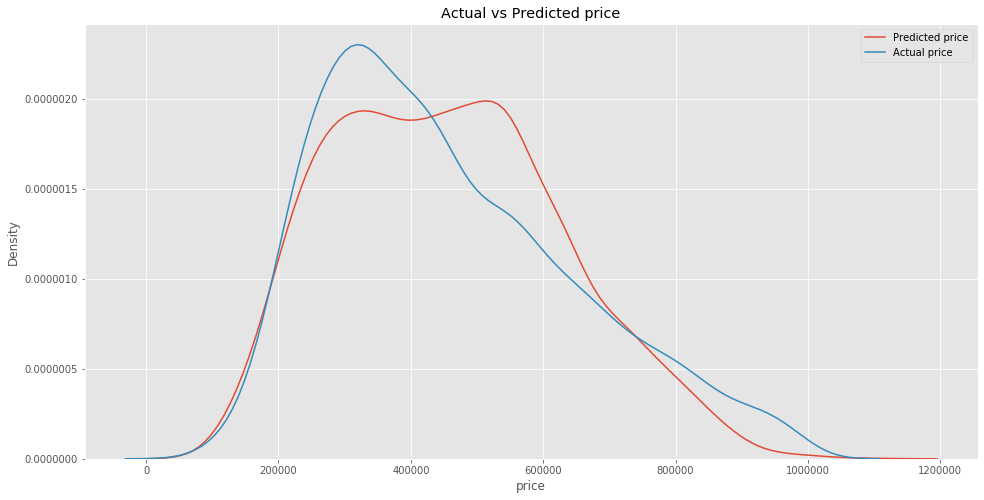

In [79]:
plt.figure(figsize=(16,8))
sns.distplot(yhat, hist = False, label = f'Predicted {outcome}')
sns.distplot(y_test, hist = False, label = f'Actual {outcome}')

plt.title(f'Actual vs Predicted {outcome}')
plt.xlabel(outcome)
plt.ylabel('Density')
plt.show()
#plt.savefig('model.png')

In [82]:
#interactions
from itertools import combinations

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=0)
regression = LinearRegression()

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
Top 3 interactions: [('sqft_living', 'zipcode_98023', 0.808), ('sqft_living', 'zipcode_98042', 0.808), ('sqft_living', 'zipcode_98103', 0.808)]


In [83]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['sqft_living*zipcode_98023'] = final['sqft_living'] * final['zipcode_98023']
final['sqft_living*zipcode_98042'] = final['sqft_living'] * final['zipcode_98042']
final['sqft_living*zipcode_98103'] = final['sqft_living'] * final['zipcode_98103']

final_model = np.mean(cross_val_score(regression, final, y, scoring='r2', cv=crossvalidation))

final_model

0.8098874686049488

In [72]:
grouped_by_zipcode_df = pd.DataFrame( cropped_df.groupby('zipcode')['price'].mean() ).reset_index()

# grouped_by_zipcode_df.min() #zipcode 98001, price 233999.61
# grouped_by_zipcode_df.max() #zipcode 98199, price 881000.00

zipcode     98199.0
price      881000.0
dtype: float64

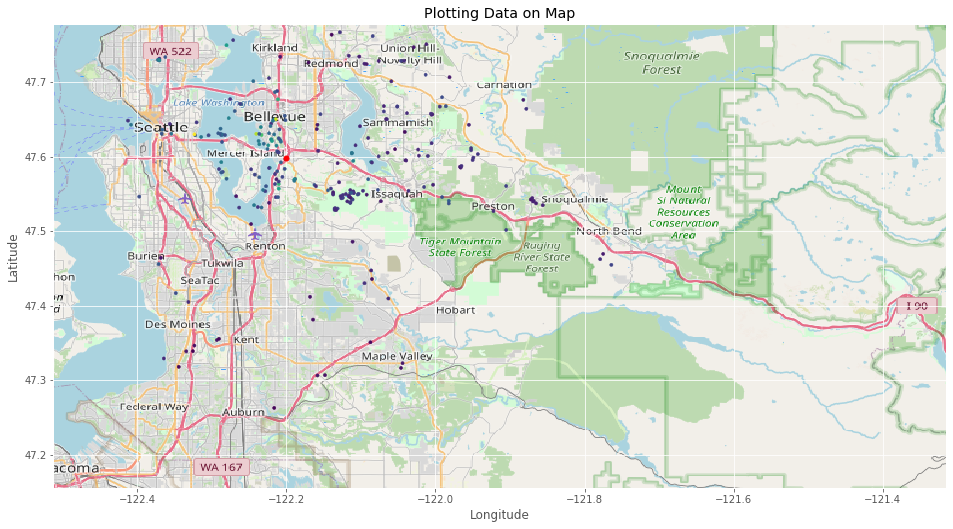

In [47]:
fig, ax = plt.subplots(figsize = (16,10))
ax.scatter(sqft_living_outliers_df.long, sqft_living_outliers_df.lat, zorder=1, alpha= 1, c=sqft_living_outliers_df.price, s=10)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_title('Plotting Data on Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.plot(-122.2,47.5983,c='r',markersize=5, marker='o') # Most expensive house
ax.imshow(map_img, zorder=0, extent = BBox, aspect= 'equal');

In [69]:
#import chart_studio.plotly as py
import plotly.offline as py
import plotly.graph_objects as go

mapbox_access_token = 'pk.eyJ1IjoidmFkaW1icyIsImEiOiJja240c3JqaTExaXh4Mm5vMmx3NDNwOHUwIn0.tHSRuXCZ3UQxUnwNQRyZCQ'

#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/Nuclear%20Waste%20Sites%20on%20American%20Campuses.csv')
site_lat = cropped_df.long
site_lon = cropped_df.lat
locations_name = cropped_df.price

data = [
    go.Scattermapbox(
        lat=list(site_lat),
        lon=list(site_lon),
        mode='markers',
        marker=dict(
            size=17,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.7
        ),
        hoverinfo='none'
    )
]


layout = go.Layout(
    title='Nuclear Waste Sites on Campus',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=47.6,
            lon=-122
        ),
        pitch=0,
        zoom=9,
        style='light'
    ),
)

fig = dict(data=data, layout=layout)

#py.iplot(fig, filename='jupyter-Nuclear Waste Sites on American Campuses')
py(fig)
#fig.layout.update()
#fig.show()
#plot( fig, filename = 'candlestick-test-3.html', validate = False )

TypeError: 'module' object is not callable

In [74]:
test_y = pd.to_datetime(cropped_df.date).dt.year
test_y.unique()

array([2014, 2015])